In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: {"username":"b23dcat011lucanh","key":"a84f9de1aadf38d641b4e8b405f8421d"}
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:03<00:00, 205MB/s] 


In [2]:
import torch
from torch import nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
image_path = []
labels = []

for i in os.listdir("/content/animal-faces/afhq"):
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")
      labels.append(label)

data_df = pd.DataFrame(zip(image_path,labels),columns= ["image_path","labels"])

print(data_df["labels"].unique())
data_df.head()


['wild' 'cat' 'dog']


,image_path,labels
0,/content/animal-faces/afhq/train/wild/flickr_w...,wild
1,/content/animal-faces/afhq/train/wild/pixabay_...,wild
2,/content/animal-faces/afhq/train/wild/flickr_w...,wild
3,/content/animal-faces/afhq/train/wild/flickr_w...,wild
4,/content/animal-faces/afhq/train/wild/flickr_w...,wild


In [4]:
train = data_df.sample(frac=0.7)
test = data_df.drop(train.index)

val = test.sample(frac=0.5)
test = test.drop(val.index)

In [5]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df["labels"])

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])



In [6]:
class CustomImageDatasets(Dataset):
  def __init__(self,dataframe,transform = None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(dataframe["labels"])).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self,idx):
    img_path = self.dataframe.iloc[idx,0]
    label = self.labels[idx]

    image = Image.open(img_path).convert('RGB')

    if self.transform:
      image = self.transform(image).to(device)

    return image, label

In [7]:
train_dataset = CustomImageDatasets(dataframe=train,transform=transform)
test_dataset = CustomImageDatasets(dataframe=test,transform=transform)
val_dataset = CustomImageDatasets(dataframe=val,transform=transform)

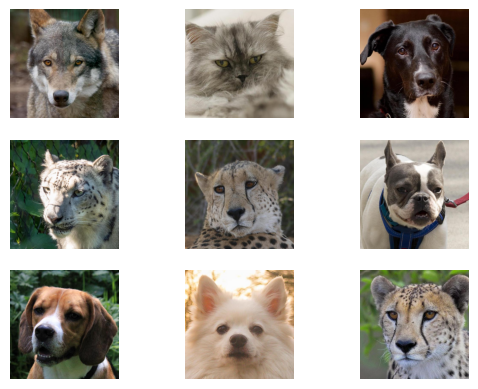

In [8]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(data_df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
    axarr[row,col].imshow(image)
    axarr[row,col].axis('off')

plt.show()

In [9]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [10]:
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [11]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3 ,32,kernel_size=3,padding=1)
    self.conv2 = nn.Conv2d(32,64, kernel_size=3,padding=1)
    self.conv3 = nn.Conv2d(64,128,kernel_size=3,padding=1)

    self.pooling = nn.MaxPool2d(2,2)

    self.relu = nn.ReLU()

    self.flatten = nn.Flatten()
    self.linear = nn.Linear((128*16*16),128)

    self.output = nn.Linear(128,len(data_df['labels'].unique()))

  def forward(self,x) :
    x = self.conv1(x)
    x = self.pooling(x)
    x = self.relu(x)

    x = self.conv2(x)
    x = self.pooling(x)
    x = self.relu(x)

    x = self.conv3(x)
    x = self.pooling(x)
    x = self.relu(x)

    x = self.flatten(x)
    x = self.linear(x)
    x = self.output(x)

    return x



In [12]:
model = Net().to(device)

In [13]:
from torchsummary import summary
summary(model,input_size= (3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(),lr=LR)

In [15]:
total_loss_train_plot = []
total_loss_validation_plot = []

total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0

  for inputs,label in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs,label)
    total_loss_train+= train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs,axis = 1)==label).sum().item()
    total_acc_train+= train_acc
    optimizer.step()

  with torch.no_grad():
    for input,label in val_loader:
      outputs = model(input)

      val_loss = criterion(outputs,label)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs,axis = 1)==label).sum().item()
      total_acc_val+=val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}''')
  print("="*25)




Epoch 1/10, Train Loss: 3.2893 Train Accuracy 80.5686
              Validation Loss: 0.3938 Validation Accuracy: 90.6198
Epoch 2/10, Train Loss: 1.4193 Train Accuracy 92.7022
              Validation Loss: 0.2495 Validation Accuracy: 93.843
Epoch 3/10, Train Loss: 0.8785 Train Accuracy 95.6337
              Validation Loss: 0.191 Validation Accuracy: 95.7438
Epoch 4/10, Train Loss: 0.5785 Train Accuracy 97.1039
              Validation Loss: 0.1835 Validation Accuracy: 95.6612
Epoch 5/10, Train Loss: 0.4184 Train Accuracy 98.0693
              Validation Loss: 0.2308 Validation Accuracy: 94.7107
Epoch 6/10, Train Loss: 0.3073 Train Accuracy 98.5209
              Validation Loss: 0.1581 Validation Accuracy: 96.281
Epoch 7/10, Train Loss: 0.2183 Train Accuracy 98.9992
              Validation Loss: 0.1902 Validation Accuracy: 95.4545
Epoch 8/10, Train Loss: 0.1552 Train Accuracy 99.2118
              Validation Loss: 0.1986 Validation Accuracy: 95.9917
Epoch 9/10, Train Loss: 0.1011 Trai

In [20]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for input,label in test_loader:
    predictions = model(input)
    loss_test = criterion(predictions,label)
    total_loss_test += loss_test.item()
    acc = (torch.argmax(predictions,axis = 1) == label).sum().item()
    total_acc_test+= acc

  print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")

Accuracy Score is: 95.246 and Loss is 0.0314


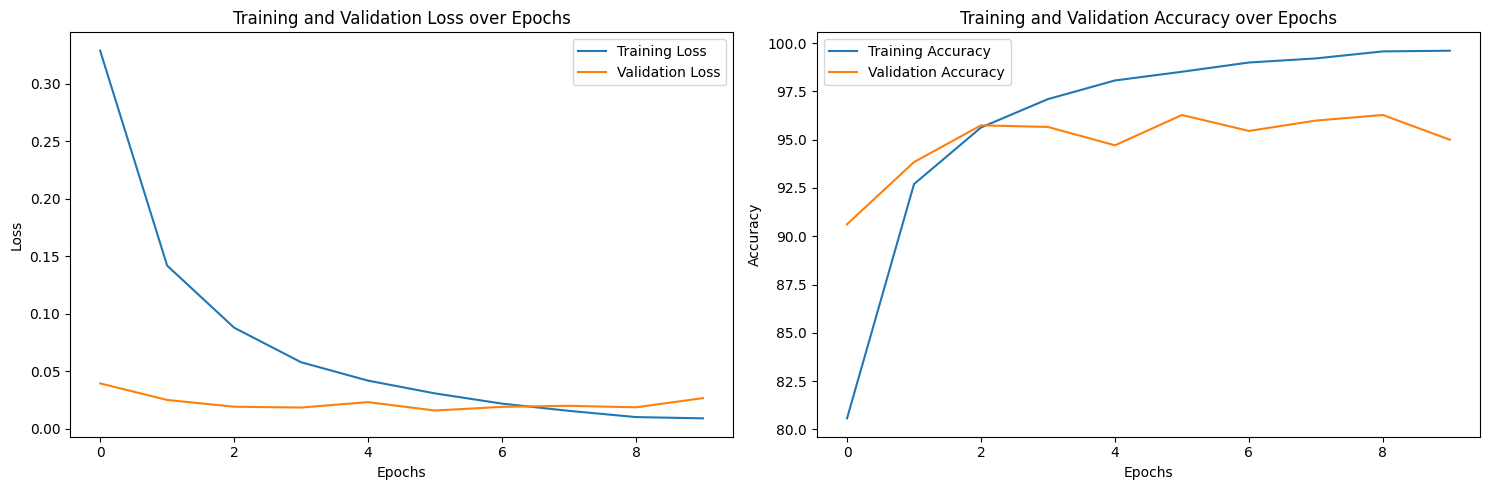

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

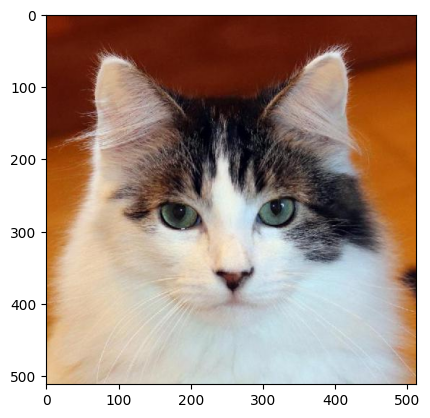


Prediction: 



array(['cat'], dtype=object)

In [23]:
def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return label_encoder.inverse_transform([output])

## Visualize the image
image = Image.open("/content/animal-faces/afhq/val/cat/flickr_cat_000008.jpg")
plt.imshow(image)
plt.show()


## Predict
print()
print("Prediction: \n")
predict_image("/content/animal-faces/afhq/val/cat/flickr_cat_000008.jpg")